In [1]:
import os
import numpy as np

from keras.utils import to_categorical
from keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Hyperparameters
base_path = "/Users/alex/Downloads/"
split = .8

num_classes = 101
learning_rate = .001

num_epochs = 20
minibatch_size = 64
val_batch_size = 56

In [10]:
raw_path = base_path + "101_ObjectCategories/"
train_path = base_path + "caltech_data/train/"
val_path = base_path + "caltech_data/val/"

In [ ]:
# Split images into training and testing
os.chdir(base_path)
!mkdir -p caltech_data/train
!mkdir -p caltech_data/val
os.chdir(raw_path)
for directory in os.listdir(raw_path):
    if directory == ".DS_Store" or directory == "BACKGROUND_Google":
        continue
    class_dict[class_num] = directory
    image_files = os.listdir(raw_path + directory + "/")
    num_images_cat = len(image_files)
    image_files = np.random.permutation(image_files)
    num_train_cat = int(np.round(split * num_images_cat))
    num_val_cat = num_images_cat - num_train_cat
    !mkdir ../caltech_data/train/{directory}
    !mkdir ../caltech_data/val/{directory}
    for i in range(num_train_cat):
        origin_path = raw_path + directory + "/" + image_files[i]
        destination_path = train_path + directory + "/" + image_files[i]
        !cp {origin_path} {destination_path}
    for i in range(num_val_cat):
        origin_path = raw_path + directory + "/" + image_files[num_train_cat + i]
        destination_path = val_path + directory + "/" + image_files[num_train_cat + i]
        !cp {origin_path} {destination_path}

In [5]:
#images_train = np.array([]).reshape(0, 224, 224, 3)
#images_val = np.array([]).reshape(0, 224, 224, 3)
#target_train_flat = np.array([])
#target_val_flat = np.array([])
#class_num = 0
#for directory in os.listdir(path):
#    if directory == ".DS_Store" or directory == "BACKGROUND_Google":
#        continue
#    dir_imgs = np.array([]).reshape(0, 224, 224, 3)
#    for filename in os.listdir(path + directory):
#        if filename == "tmp":
#            continue
#        dir_imgs = np.append(dir_imgs, cv2.resize(cv2.imread(path + directory + "/" + filename), (224, 224)).reshape(1, 224, 224, 3), axis = 0)
#    num_img_cat = dir_imgs.shape[0]
#    num_train_cat = int(np.round(split * num_img_cat))
#    num_val_cat = num_img_cat - num_train_cat
#    random_idx = np.random.permutation(num_img_cat)
#    dir_imgs = dir_imgs[random_idx,:,:,:]
#    dir_imgs_train = dir_imgs[0:num_train_cat,:,:,:]
#    dir_imgs_val = dir_imgs[num_train_cat:,:,:,:]
#    images_val = np.append(images_val, dir_imgs_val, axis=0)
#    target_val_flat = np.append(target_val_flat, np.full(num_val_cat, class_num))
#    if num_train_cat >= num_per_cat:
#        images_train = np.append(images_train, dir_imgs_train[0:num_per_cat,:,:,:], axis=0)
#        target_train_flat = np.append(target_train_flat, np.full(num_per_cat, class_num))
#    else:
#        num_mult = num_per_cat // num_train_cat
#        num_remain = num_per_cat % num_train_cat
#        new_idx = np.concatenate((np.repeat(range(num_train_cat), num_mult),
#                                  np.random.choice(num_train_cat, num_remain, replace=False)))
#        images_train = np.append(images_train, dir_imgs_train[new_idx,:,:,:], axis=0)
#        target_train_flat = np.append(target_train_flat, np.full(num_per_cat, class_num))
#    class_num += 1
#    if class_num % 10 == 0:
#        print("Read through " + str(class_num) + " classes.")
#
#target_train = to_categorical(target_train_flat)
#target_val = to_categorical(target_val_flat)
#bgr_mean = images_train.mean(axis=(0,1,2))
#print("Done.")

Read through 10 classes.
Read through 20 classes.
Read through 30 classes.
Read through 40 classes.
Read through 50 classes.
Read through 60 classes.
Read through 70 classes.
Read through 80 classes.
Read through 90 classes.
Read through 100 classes.
Done.


In [6]:
#print(images_train.shape)
#print(target_train.shape)
#print(images_val.shape)
#print(target_val.shape)
#num_train = images_train.shape[0]
#num_val = images_val.shape[0]

(6060, 224, 224, 3)
(6060, 101)
(1736, 224, 224, 3)
(1736, 101)


In [3]:
# Identity residual block
def id_block(X, filters, block_num):
    X_cut = X
    
    X = Conv2D(filters[0], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_1")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_1")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[0], [3, 3], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_2")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_2")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[1], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_3")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_3")(X)
    X = Activation("relu")(X)

    X = Add()([X, X_cut])
    X = Activation("relu")(X)
    
    return X

In [4]:
# Convolutional residual block
def conv_block(X, filters, s, block_num):
    X_cut = X
    
    X = Conv2D(filters[0], [1, 1], strides = [s, s], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_1")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_1")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[0], [3, 3], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_2")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_2")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[1], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_" + str(block_num) + "_3")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_3")(X)
    X = Activation("relu")(X)
    
    X_cut = Conv2D(filters[1], [1, 1], strides = [s, s], padding = "same",
                   kernel_regularizer = l2(.0001),
                   name = "conv_" + str(block_num) + "_cut")(X_cut)
    X_cut = BatchNormalization(name = "bn_" + str(block_num) + "_cut")(X_cut)
    
    X = Add()([X, X_cut])
    X = Activation("relu")(X)
    
    return X

In [5]:
# ResNet50 architecture
def ResNet50(input_shape, num_classes):
    X_input = Input(input_shape)
    
    # Phase 1
    X = Conv2D(64, [7, 7], strides = [2, 2], padding = "same",
               kernel_regularizer = l2(.0001),
               name = "conv_1")(X_input)
    X = BatchNormalization(name = "bn_1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D([3, 3], strides=[2, 2], padding = "same")(X)
    
    # Phase 2
    X = conv_block(X, [64, 256], s = 2, block_num = 2)
    X = id_block(X, [64, 256], block_num = 3)
    X = id_block(X, [64, 256], block_num = 4)
    
    # Phase 3
    X = conv_block(X, [128, 512], s = 2, block_num = 5)
    X = id_block(X, [128, 512], block_num = 6)
    X = id_block(X, [128, 512], block_num = 7)
    X = id_block(X, [128, 512], block_num = 8)
    
    # Phase 4
    X = conv_block(X, [256, 1024], s = 2, block_num = 9)
    X = id_block(X, [256, 1024], block_num = 10)
    X = id_block(X, [256, 1024], block_num = 11)
    X = id_block(X, [256, 1024], block_num = 12)
    X = id_block(X, [256, 1024], block_num = 13)
    X = id_block(X, [256, 1024], block_num = 14)
    
    # Phase 5
    X = conv_block(X, [512, 2048], s = 2, block_num = 15)
    X = id_block(X, [512, 2048], block_num = 16)
    X = id_block(X, [512, 2048], block_num = 17)
    
    # Pool and softmax
    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation = "softmax", name = "softmax")(X)
    
    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

In [6]:
resnet50_model = ResNet50(input_shape = (224, 224, 3), num_classes = num_classes)

In [7]:
adam = Adam(lr = learning_rate)
resnet50_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
rgb_mean = [138.95, 132.34, 124.39]
def center_image(image):    
    image[:,:,0] -= rgb_mean[0]
    image[:,:,1] -= rgb_mean[1]
    image[:,:,2] -= rgb_mean[2]
    return image

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = center_image,
    rescale = 1./255)

val_datagen = ImageDataGenerator(
    preprocessing_function = center_image,
    rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (224, 224),
        batch_size = minibatch_size)

val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (224, 224),
        batch_size = val_batch_size,
        shuffle=False)

Found 6941 images belonging to 101 classes.
Found 1736 images belonging to 101 classes.


In [12]:
history_1 = resnet50_model.fit_generator(train_generator,
                                         steps_per_epoch = int(np.ceil(6941 / minibatch_size)),
                                         epochs = num_epochs,
                                         validation_data = val_generator,
                                         validation_steps = 1736 // val_batch_size)

Epoch 1/20
109/109 [==============================] - 1498s 14s/step - loss: 6.5729 - acc: 0.1399 - val_loss: 6.4642 - val_acc: 0.1636
Epoch 2/20
109/109 [==============================] - 1488s 14s/step - loss: 5.9674 - acc: 0.1899 - val_loss: 7.3871 - val_acc: 0.1532
Epoch 3/20
109/109 [==============================] - 1486s 14s/step - loss: 5.8111 - acc: 0.2148 - val_loss: 5.3762 - val_acc: 0.2368
Epoch 4/20
109/109 [==============================] - 1484s 14s/step - loss: 5.3478 - acc: 0.2479 - val_loss: 5.0782 - val_acc: 0.2373
Epoch 5/20
109/109 [==============================] - 1483s 14s/step - loss: 5.0462 - acc: 0.2782 - val_loss: 5.1144 - val_acc: 0.2074
Epoch 6/20
109/109 [==============================] - 1484s 14s/step - loss: 5.0376 - acc: 0.2771 - val_loss: 6.9063 - val_acc: 0.2137
Epoch 7/20
109/109 [==============================] - 1484s 14s/step - loss: 4.6677 - acc: 0.3074 - val_loss: 4.6306 - val_acc: 0.2921
Epoch 8/20
109/109 [==============================] - 1

In [13]:
history_2 = resnet50_model.fit_generator(train_generator,
                                         steps_per_epoch = int(np.ceil(6941 / minibatch_size)),
                                         epochs = num_epochs,
                                         validation_data = val_generator,
                                         validation_steps = 1736 // val_batch_size)

Epoch 1/20
109/109 [==============================] - 1483s 14s/step - loss: 3.8055 - acc: 0.4155 - val_loss: 11.2191 - val_acc: 0.0565
Epoch 2/20
109/109 [==============================] - 1480s 14s/step - loss: 4.0407 - acc: 0.3580 - val_loss: 14.9658 - val_acc: 0.0196
Epoch 3/20
109/109 [==============================] - 1485s 14s/step - loss: 4.9325 - acc: 0.2821 - val_loss: 15.7896 - val_acc: 0.0046
Epoch 4/20
109/109 [==============================] - 1486s 14s/step - loss: 4.6443 - acc: 0.3277 - val_loss: 4.9763 - val_acc: 0.2535
Epoch 5/20
109/109 [==============================] - 1482s 14s/step - loss: 4.2762 - acc: 0.3709 - val_loss: 4.6935 - val_acc: 0.3255
Epoch 6/20
109/109 [==============================] - 1478s 14s/step - loss: 4.3668 - acc: 0.3749 - val_loss: 5.1564 - val_acc: 0.2137
Epoch 7/20
109/109 [==============================] - 1482s 14s/step - loss: 4.7478 - acc: 0.3221 - val_loss: 11.0263 - val_acc: 0.0789
Epoch 8/20
109/109 [==============================]

In [14]:
history_3 = resnet50_model.fit_generator(train_generator,
                                         steps_per_epoch = int(np.ceil(6941 / minibatch_size)),
                                         epochs = num_epochs,
                                         validation_data = val_generator,
                                         validation_steps = 1736 // val_batch_size)

Epoch 1/20
109/109 [==============================] - 1486s 14s/step - loss: 3.4183 - acc: 0.4724 - val_loss: 4.5296 - val_acc: 0.3514
Epoch 2/20
109/109 [==============================] - 1486s 14s/step - loss: 3.5739 - acc: 0.4620 - val_loss: 4.1170 - val_acc: 0.3675
Epoch 3/20
109/109 [==============================] - 1491s 14s/step - loss: 3.3370 - acc: 0.4937 - val_loss: 3.4584 - val_acc: 0.4643
Epoch 4/20
109/109 [==============================] - 1492s 14s/step - loss: 3.2019 - acc: 0.5093 - val_loss: 3.5373 - val_acc: 0.4522
Epoch 5/20
109/109 [==============================] - 1499s 14s/step - loss: 3.1778 - acc: 0.5061 - val_loss: 5.3171 - val_acc: 0.2298
Epoch 6/20
109/109 [==============================] - 1491s 14s/step - loss: 3.2100 - acc: 0.5079 - val_loss: 10.6980 - val_acc: 0.2103
Epoch 7/20
109/109 [==============================] - 1488s 14s/step - loss: 3.2596 - acc: 0.5011 - val_loss: 3.4929 - val_acc: 0.4343
Epoch 8/20
109/109 [==============================] - 

In [15]:
history_4 = resnet50_model.fit_generator(train_generator,
                                         steps_per_epoch = int(np.ceil(6941 / minibatch_size)),
                                         epochs = num_epochs,
                                         validation_data = val_generator,
                                         validation_steps = 1736 // val_batch_size)

Epoch 1/20
109/109 [==============================] - 1508s 14s/step - loss: 2.6255 - acc: 0.5987 - val_loss: 3.7317 - val_acc: 0.3808
Epoch 2/20
109/109 [==============================] - 1505s 14s/step - loss: 2.6437 - acc: 0.5947 - val_loss: 2.8272 - val_acc: 0.5334
Epoch 3/20
109/109 [==============================] - 1504s 14s/step - loss: 2.6796 - acc: 0.5872 - val_loss: 3.8137 - val_acc: 0.4631
Epoch 4/20
109/109 [==============================] - 1506s 14s/step - loss: 2.4817 - acc: 0.6181 - val_loss: 2.8365 - val_acc: 0.5490
Epoch 5/20
109/109 [==============================] - 1508s 14s/step - loss: 2.5715 - acc: 0.6180 - val_loss: 4.8934 - val_acc: 0.3733
Epoch 6/20
109/109 [==============================] - 1505s 14s/step - loss: 2.6955 - acc: 0.6165 - val_loss: 3.9255 - val_acc: 0.4608
Epoch 7/20
109/109 [==============================] - 1505s 14s/step - loss: 2.5708 - acc: 0.6327 - val_loss: 4.0701 - val_acc: 0.3934
Epoch 8/20
109/109 [==============================] - 1

In [16]:
history_5 = resnet50_model.fit_generator(train_generator,
                                         steps_per_epoch = int(np.ceil(6941 / minibatch_size)),
                                         epochs = num_epochs,
                                         validation_data = val_generator,
                                         validation_steps = 1736 // val_batch_size)

Epoch 1/20
109/109 [==============================] - 1501s 14s/step - loss: 2.7300 - acc: 0.6087 - val_loss: 10.5006 - val_acc: 0.0795
Epoch 2/20
109/109 [==============================] - 1502s 14s/step - loss: 2.7806 - acc: 0.6153 - val_loss: 5.9459 - val_acc: 0.3283
Epoch 3/20
109/109 [==============================] - 1503s 14s/step - loss: 2.5009 - acc: 0.6400 - val_loss: 5.5445 - val_acc: 0.3756
Epoch 4/20
109/109 [==============================] - 1501s 14s/step - loss: 2.3529 - acc: 0.6691 - val_loss: 14.5868 - val_acc: 0.0829
Epoch 5/20
109/109 [==============================] - 1503s 14s/step - loss: 2.5490 - acc: 0.6449 - val_loss: 4.6948 - val_acc: 0.4240
Epoch 6/20
109/109 [==============================] - 1503s 14s/step - loss: 2.2424 - acc: 0.6906 - val_loss: 2.6729 - val_acc: 0.5835
Epoch 7/20
109/109 [==============================] - 1503s 14s/step - loss: 2.6677 - acc: 0.6313 - val_loss: 5.6662 - val_acc: 0.3439
Epoch 8/20
109/109 [==============================] -

In [22]:
all_loss = []
all_acc = []
all_val_acc = []
for hist in [history_1, history_2, history_3, history_4, history_5]:
    all_loss += hist.history["loss"]
    all_acc += hist.history["acc"]
    all_val_acc += hist.history["val_acc"]

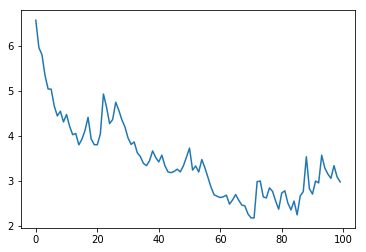

In [24]:
plt.plot(all_loss)

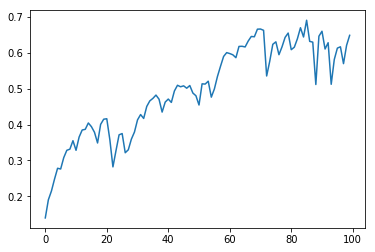

In [25]:
plt.plot(all_acc)

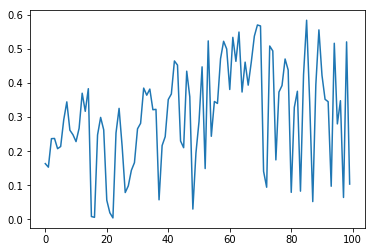

In [26]:
plt.plot(all_val_acc)

In [16]:
bgr_mean

array([124.38554073, 132.33668062, 138.94874191])

In [33]:
import keras.backend as K

In [36]:
print(K.eval(resnet50_model.optimizer.lr))

0.0002


In [35]:
K.set_value(resnet50_model.optimizer.lr, .0002)